### Load cross fixation data

In [2]:
%load_ext autoreload
%autoreload 2

import s3fs
import pandas as pd
import os
import numpy as np

from lfads import LFADS_Net, LFADS_SingleSession_Net
import torch
import torch.optim as opt
from scheduler import LFADS_Scheduler
from plotter import Plotter
from trainer import RunManager

import yaml

from synthetic_data import LorenzSystem, EmbeddedLowDNetwork
from objective import SVLAE_Loss, LFADS_Loss, LogLikelihoodPoisson, LogLikelihoodPoissonSimplePlusL1, LogLikelihoodPoissonSimple, LogLikelihoodGaussian

from utils import load_parameters
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pickle


/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

NHP_WCST_DIR = 'nhp-lfp/wcst-preprocessed/'


# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = os.path.join(NHP_WCST_DIR, "rawdata", "sub-" + str(subject), "sess-" + str(session), "behavior", "sub-" + str(subject) + "_sess-" + str(session) + "_object_features.csv")
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
valid_beh["PrevResponse"] = valid_beh["Response"].shift()  
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]



/tmp/ipykernel_1472244/2887542036.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_beh["PrevResponse"] = valid_beh["Response"].shift()


In [4]:
pre_interval = 0
post_interval = 350
interval_size = 50
frs = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_crossfixation_{post_interval}_{interval_size}_bins.pickle"))
frs = frs[frs.TrialNumber.isin(valid_beh.TrialNumber)]

In [5]:
# get data in trials x time x neurons
num_time_bins = len(frs["TimeBins"].unique())
num_units = len(frs["UnitID"].unique())
num_trials = len(frs["TrialNumber"].unique())
sorted = frs.sort_values(by=["UnitID", "TimeBins", "TrialNumber"])
# currently in neurons x time x trials
spike_data = sorted["SpikeCounts"].to_numpy().reshape((num_units, num_time_bins, num_trials))
# want trials x time x neurons
spike_data = np.transpose(spike_data, (2, 1, 0))


In [6]:
spike_data.shape

(1692, 7, 58)

In [7]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'; print(device)
device = 'cpu'
train_idxs, valid_idxs = train_test_split(np.arange(spike_data.shape[1]), train_size=0.8)
train_spikes = spike_data[:, train_idxs, :]

valid_spikes = spike_data[:, valid_idxs, :]

train_data  = torch.Tensor(train_spikes).to(device)
valid_data  = torch.Tensor(valid_spikes).to(device)
train_ds    = torch.utils.data.TensorDataset(train_data)
valid_ds    = torch.utils.data.TensorDataset(valid_data)
train_dl    = torch.utils.data.DataLoader(train_ds, batch_size = 50, shuffle=True)
valid_dl    = torch.utils.data.DataLoader(valid_ds, batch_size = valid_data.shape[0])

### Train a net with latent size 2, visualize

In [8]:
hyperparameter_path = 'lfads_cross_fixation_hyperparams.yaml'
hyperparams = load_parameters(hyperparameter_path)
model = LFADS_SingleSession_Net(
    input_size           = 58,
    factor_size          = hyperparams['model']['factor_size'],
    g_encoder_size       = hyperparams['model']['g_encoder_size'],
    c_encoder_size       = hyperparams['model']['c_encoder_size'],
    g_latent_size        = hyperparams['model']['g_latent_size'],
    u_latent_size        = hyperparams['model']['u_latent_size'],
    controller_size      = hyperparams['model']['controller_size'],
    generator_size       = hyperparams['model']['generator_size'],
    prior                = hyperparams['model']['prior'],
    clip_val             = hyperparams['model']['clip_val'],
    dropout              = hyperparams['model']['dropout'],
    do_normalize_factors = hyperparams['model']['normalize_factors'],
    max_norm             = hyperparams['model']['max_norm'],
    device               = device
).to(device)

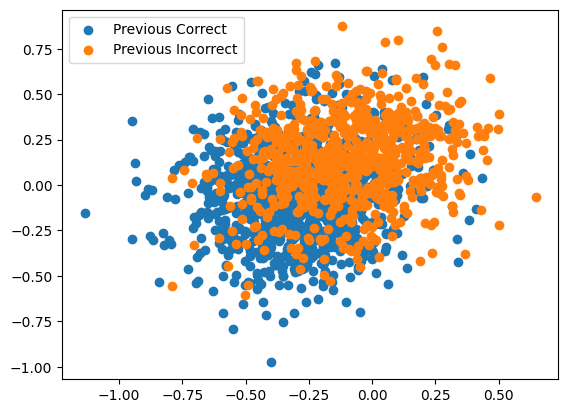

In [9]:
out = model(torch.Tensor(spike_data))

idx_prev_cor = np.argwhere(valid_beh.PrevResponse.values=="Correct")[:,0]
idx_prev_inc = np.argwhere(valid_beh.PrevResponse.values=="Incorrect")[:,0]

fig, ax = plt.subplots()
posterior_means = model.g_posterior_mean.detach().numpy()
# ax.plot(run_manager.loss_dict["train"]["total"], label="Total Loss Train")
ax.scatter(posterior_means[idx_prev_cor, 0], posterior_means[idx_prev_cor, 1], label="Previous Correct")
ax.scatter(posterior_means[idx_prev_inc, 0], posterior_means[idx_prev_inc, 1], label="Previous Incorrect")
ax.legend()

In [10]:
dt = 0.05
loglikelihood = LogLikelihoodPoisson(dt=dt, device=device)
objective = LFADS_Loss(
    loglikelihood=loglikelihood,
    loss_weight_dict={
        "kl": hyperparams['objective']["kl"],
        "l2": hyperparams["objective"]["l2"]},
    l2_con_scale=hyperparams["objective"]["l2_con_scale"],
    l2_gen_scale=hyperparams["objective"]["l2_gen_scale"]
).to(device)

In [11]:


optimizer = opt.Adam([p for p in model.parameters() if p.requires_grad],
                     lr=hyperparams['optimizer']['lr_init'],
                     betas=hyperparams['optimizer']['betas'],
                     eps=hyperparams['optimizer']['eps'])

scheduler = LFADS_Scheduler(optimizer      = optimizer,
                            mode           = 'min',
                            factor         = hyperparams['scheduler']['scheduler_factor'],
                            patience       = hyperparams['scheduler']['scheduler_patience'],
                            verbose        = True,
                            threshold      = 1e-4,
                            threshold_mode = 'abs',
                            cooldown       = hyperparams['scheduler']['scheduler_cooldown'],
                            min_lr         = hyperparams['scheduler']['lr_min'])

In [17]:
run_manager = RunManager(model      = model,
                         objective  = objective,
                         optimizer  = optimizer,
                         scheduler  = scheduler,
                         train_dl   = train_dl,
                         valid_dl   = valid_dl,
                         transforms = None,  # transforms,
                         writer     = None,
                         plotter    = None,
                         max_epochs = 100,
                         save_loc   = "data/lfadscross",
                         do_health_check = False)

In [ ]:
run_manager.run()
torch.save(model, "data/trained_lfads.pth")
with open("data/loss_data.pickle", "wb") as f:
    pickle.dump(run_manager.loss_dict, f)

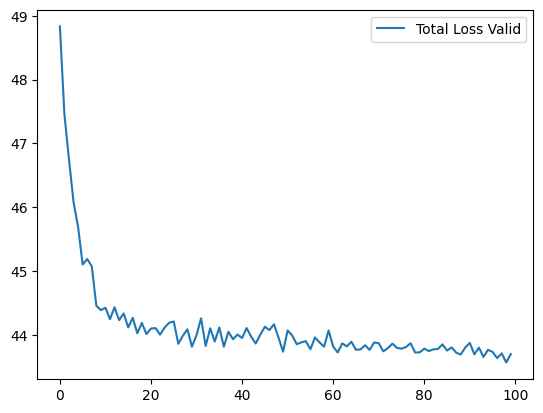

In [3]:
loss_file = open("data/loss_data.pickle", "rb")
loss_dict = pickle.load(loss_file)
fig, ax = plt.subplots()
# ax.plot(run_manager.loss_dict["train"]["total"], label="Total Loss Train")
ax.plot(loss_dict["valid"]["total"], label="Total Loss Valid")
ax.legend()

### Grab best model, run through all trials, plot out posterior means

In [18]:
best = torch.load("data/lfadscrosscheckpoints/best.pth")
best_model = LFADS_SingleSession_Net(
    input_size           = 58,
    factor_size          = hyperparams['model']['factor_size'],
    g_encoder_size       = hyperparams['model']['g_encoder_size'],
    c_encoder_size       = hyperparams['model']['c_encoder_size'],
    g_latent_size        = hyperparams['model']['g_latent_size'],
    u_latent_size        = hyperparams['model']['u_latent_size'],
    controller_size      = hyperparams['model']['controller_size'],
    generator_size       = hyperparams['model']['generator_size'],
    prior                = hyperparams['model']['prior'],
    clip_val             = hyperparams['model']['clip_val'],
    dropout              = hyperparams['model']['dropout'],
    do_normalize_factors = hyperparams['model']['normalize_factors'],
    max_norm             = hyperparams['model']['max_norm'],
    device               = device
).to(device)
best_model.load_state_dict(best["net"])

<All keys matched successfully>

In [19]:
out = best_model(torch.Tensor(spike_data))

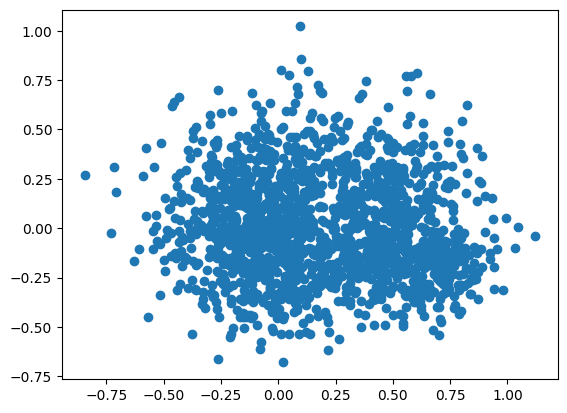

In [20]:
fig, ax = plt.subplots()
posterior_means = best_model.g_posterior_mean.detach().numpy()
# ax.plot(run_manager.loss_dict["train"]["total"], label="Total Loss Train")
ax.scatter(posterior_means[:, 0], posterior_means[:, 1])

In [4]:
def label_trials(block_group):
    block_len = len(block_group)
    block_group["TrialUntilRuleChange"] = block_len - block_group["TrialAfterRuleChange"]
    last_eight = block_group[block_group["TrialUntilRuleChange"] <= 8]
    return last_eight
block_groups = valid_beh.groupby(["BlockNumber"], as_index=False)
only_last_eight = block_groups.apply(label_trials).reset_index()

In [26]:
idx_cyan = np.argwhere(
    np.isin(valid_beh.TrialNumber.values, only_last_eight.TrialNumber.values) & 
    (valid_beh.CurrentRule.values == "CYAN")
)[:,0]
idx_triangle = np.argwhere(
    np.isin(valid_beh.TrialNumber.values, only_last_eight.TrialNumber.values) & 
    (valid_beh.CurrentRule.values == "TRIANGLE")
)[:,0]
idx_last_eight = np.argwhere(np.isin(valid_beh.TrialNumber.values, only_last_eight.TrialNumber.values))


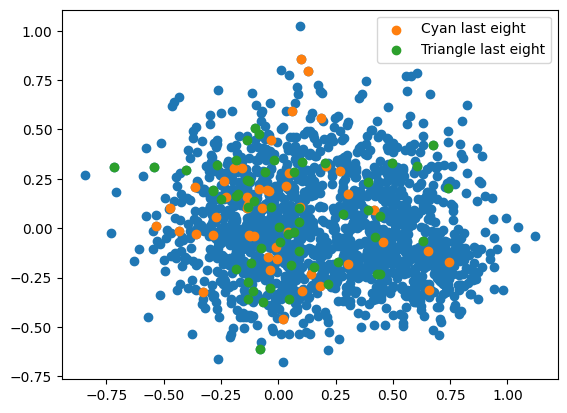

In [25]:
fig, ax = plt.subplots()
posterior_means = best_model.g_posterior_mean.detach().numpy()
# ax.plot(run_manager.loss_dict["train"]["total"], label="Total Loss Train")
ax.scatter(posterior_means[:, 0], posterior_means[:, 1])
ax.scatter(posterior_means[idx_cyan, 0], posterior_means[idx_cyan, 1], label="Cyan last eight")
ax.scatter(posterior_means[idx_triangle, 0], posterior_means[idx_triangle, 1], label="Triangle last eight")
ax.legend()


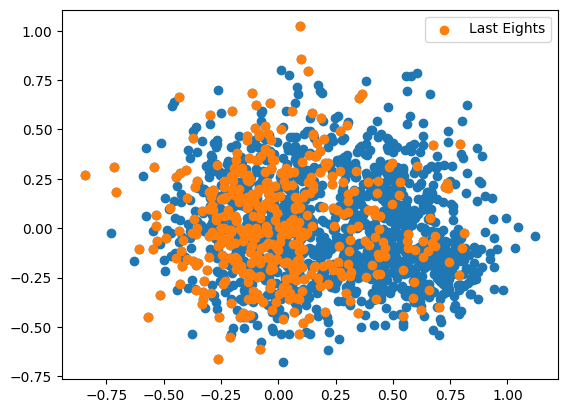

In [27]:
fig, ax = plt.subplots()
posterior_means = best_model.g_posterior_mean.detach().numpy()
# ax.plot(run_manager.loss_dict["train"]["total"], label="Total Loss Train")
ax.scatter(posterior_means[:, 0], posterior_means[:, 1])
ax.scatter(posterior_means[idx_last_eight, 0], posterior_means[idx_last_eight, 1], label="Last Eights")
ax.legend()

In [29]:
idx_prev_cor = np.argwhere(valid_beh.PrevResponse.values=="Correct")[:,0]
idx_prev_inc = np.argwhere(valid_beh.PrevResponse.values=="Incorrect")[:,0]

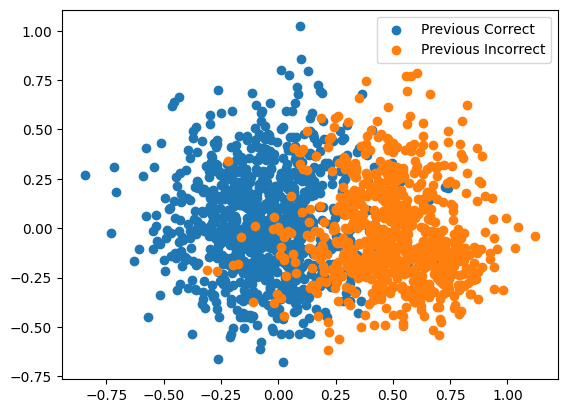

In [32]:
fig, ax = plt.subplots()
posterior_means = best_model.g_posterior_mean.detach().numpy()
# ax.plot(run_manager.loss_dict["train"]["total"], label="Total Loss Train")
ax.scatter(posterior_means[idx_prev_cor, 0], posterior_means[idx_prev_cor, 1], label="Previous Correct")
ax.scatter(posterior_means[idx_prev_inc, 0], posterior_means[idx_prev_inc, 1], label="Previous Incorrect")
ax.legend()

### Look at model with 10 latents

In [21]:
hyperparameter_path = 'lfads_cross_fixation_hyperparams.yaml'
hyperparams = load_parameters(hyperparameter_path)
model = LFADS_SingleSession_Net(
    input_size           = 58,
    factor_size          = hyperparams['model']['factor_size'],
    g_encoder_size       = hyperparams['model']['g_encoder_size'],
    c_encoder_size       = hyperparams['model']['c_encoder_size'],
    g_latent_size        = 2,
    u_latent_size        = hyperparams['model']['u_latent_size'],
    controller_size      = hyperparams['model']['controller_size'],
    generator_size       = hyperparams['model']['generator_size'],
    prior                = hyperparams['model']['prior'],
    clip_val             = hyperparams['model']['clip_val'],
    dropout              = hyperparams['model']['dropout'],
    do_normalize_factors = hyperparams['model']['normalize_factors'],
    max_norm             = hyperparams['model']['max_norm'],
    device               = device
).to(device)

In [19]:
run_manager = RunManager(model      = model,
                         objective  = objective,
                         optimizer  = optimizer,
                         scheduler  = scheduler,
                         train_dl   = train_dl,
                         valid_dl   = valid_dl,
                         transforms = None,  # transforms,
                         writer     = None,
                         plotter    = None,
                         max_epochs = 100,
                         save_loc   = "data/lfadscross2latents",
                         do_health_check = False)

In [20]:
run_manager.run()
with open("data/loss_data_15_latents.pickle", "wb") as f:
    pickle.dump(run_manager.loss_dict, f)

Epoch     1, Epoch time = 0.363 s, Loss (train, valid):  recon (196.619, 80.308), kl (37.009, 39.577), total (237.259, 124.217), l2 (3.630)
Epoch     2, Epoch time = 0.371 s, Loss (train, valid):  recon (196.166, 80.252), kl (44.208, 39.577), total (244.705, 124.160), l2 (4.331)
Epoch     3, Epoch time = 0.371 s, Loss (train, valid):  recon (196.454, 80.344), kl (44.110, 39.577), total (244.895, 124.252), l2 (4.331)
Epoch     4, Epoch time = 0.397 s, Loss (train, valid):  recon (196.106, 80.609), kl (44.151, 39.577), total (244.589, 124.518), l2 (4.331)
Epoch     5, Epoch time = 0.390 s, Loss (train, valid):  recon (196.437, 80.677), kl (44.050, 39.577), total (244.818, 124.585), l2 (4.331)
Epoch     6, Epoch time = 0.420 s, Loss (train, valid):  recon (196.418, 80.457), kl (44.071, 39.577), total (244.820, 124.365), l2 (4.331)
Epoch     7, Epoch time = 0.419 s, Loss (train, valid):  recon (196.461, 80.249), kl (44.225, 39.577), total (245.017, 124.158), l2 (4.331)
Epoch 00208: reducin

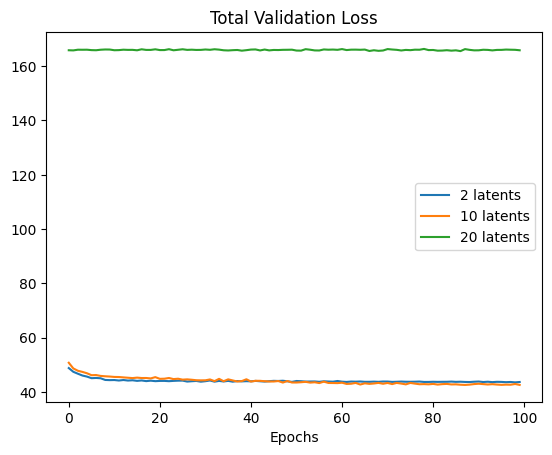

In [22]:
loss_file = open("data/loss_data.pickle", "rb")
loss_dict = pickle.load(open("data/loss_data.pickle", "rb"))
loss_dict_10 = pickle.load(open("data/loss_data_10_latents.pickle", "rb"))
loss_dict_20 = pickle.load(open("data/loss_data_20_latents.pickle", "rb"))

fig, ax = plt.subplots()
# ax.plot(run_manager.loss_dict["train"]["total"], label="Total Loss Train")
ax.plot(loss_dict["valid"]["total"], label="2 latents")
ax.plot(loss_dict_10["valid"]["total"], label="10 latents")
ax.plot(loss_dict_20["valid"]["total"], label="20 latents")

ax.set_xlabel("Epochs")
ax.set_title("Total Validation Loss")
ax.legend()